# **Data Science Academy - Curso Python Fundamentos**

## Análise Exploratória de Dados com Python e Linguagem SQL

Neste Mini-Projeto vamos realizar uma análise exploratória de dados usando Linguagem Python, Linguagem SQL e Banco de Dados SQLite. Usaremos dados reais disponíveis publicamente, dados sobre filmes no <a href="https://www.imdb.com/interfaces/">IMDB</a>.

Ao aplicar Análise Exploratória de Dados vamos responder a estas 10 perguntas:

- 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?
- 2- Qual o Número de Títulos Por Gênero?
- 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?
- 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?
- 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?
- 6- Qual o Filme Com Maior Tempo de Duração? Calcule os Percentis.
- 7- Qual a Relação Entre Duração e Gênero?
- 8- Qual o Número de Filmes Produzidos Por País?
- 9- Quais São os Top 10 Melhores Filmes?
- 10- Quais São os Top 10 Piores Filmes?

## Instalando e Carregando Pacotes

In [2]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.2


In [3]:
# Instalação de pacotes:
!pip install -q imdb-sqlite
!pip install -q pycountry

In [4]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

## Carregando os Dados

Primeiro temos que baixar os dados!

In [5]:
%%time
!imdb-sqlite

2022-04-17 17:01:42,077 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 6.84 ms, sys: 15.7 ms, total: 22.5 ms
Wall time: 245 ms


Após a aquisição dos dados, nos conectaremos com o banco de dados e extraimos a lista de tabelas para analisar o que temos disponível. Em seguida converteremos o DataFrame em uma lista e percorreremos a lista de tabelas para extrair o esquema de cada uma, assim saberemos o tipo de dado existente em cada uma.

In [6]:
# Conecta no banco de dados
conn = sqlite3.connect("imdb.db")

In [7]:
# Extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [8]:
# Tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [9]:
# Visualiza o resultado
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [10]:
# Vamos converter o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [11]:
# Vamos percorrer a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




## Agora começaremos a Análise Exploratória dos Dados.

## 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?

Quais são os principais tipos (categorias) dos títulos (filmes)?

Para responder essa pergunta criaremos uma consulta SQL que agrupará os filmes por categoria (ex: filme, seriados, curtas, etc). Em seguida, extraimos o resultado dessa consulta e o conferimos. Depois, criaremos um nova coluna para inserir os dados percentuais para cada categoria. Como uma forma de melhorar a compreensão desses dados optamos por manter apenas 4 categorias, onde 3 destas categorias são as que apresentam o maior número de titulos e uma quarta agrupando todos dos demais (others). Por fim, plotaremos o resultado em um gráfico de rosca.

In [12]:
# Cria a consulta SQL
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type''' 

In [13]:
# Extrai o resultado
resultado1 = pd.read_sql_query(consulta1, conn)

In [14]:
# Visualiza o resultado
display(resultado1)

,type,COUNT
0,movie,607342
1,short,864919
2,tvEpisode,6640383
3,tvMiniSeries,43007
4,tvMovie,135731
5,tvPilot,2
6,tvSeries,223550
7,tvShort,10519
8,tvSpecial,36557
9,video,259250


In [15]:
# Vamos calcular o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [16]:
# Visualiza o resultado
display(resultado1)

,type,COUNT,percentual
0,movie,607342,6.860955
1,short,864919,9.770723
2,tvEpisode,6640383,75.014361
3,tvMiniSeries,43007,0.485837
4,tvMovie,135731,1.533311
5,tvPilot,2,0.000023
6,tvSeries,223550,2.525375
7,tvShort,10519,0.118830
8,tvSpecial,36557,0.412973
9,video,259250,2.928667


In [17]:
# Cria um dicionário vazio
others = {}

# Filtra o percentual em 5% e soma o total
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

# Grava o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

# Ajusta o nome
others['type'] = 'others'

In [18]:
# Visualiza
others

{'COUNT': 739505, 'percentual': 8.353960151371151, 'type': 'others'}

In [19]:
# Filtra o dataframe de resultado
resultado1 = resultado1[resultado1['percentual'] > 5]

In [20]:
# Append com o dataframe de outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

In [21]:
# Ordena o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending = False)

In [22]:
# Visualiza
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6640383,75.014361
1,short,864919,9.770723
3,others,739505,8.353960
0,movie,607342,6.860955


In [23]:
# Ajusta os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

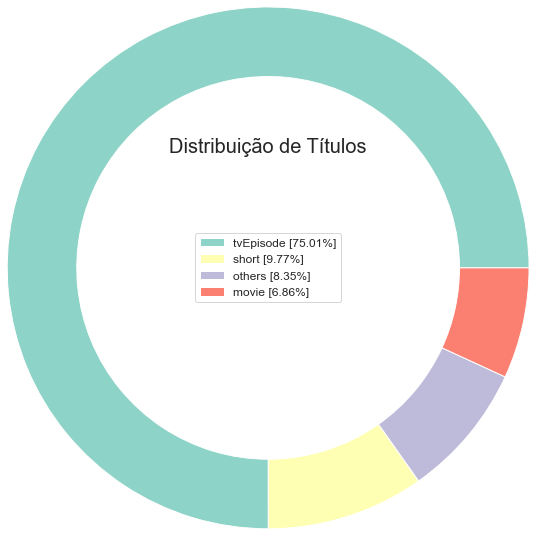

In [24]:
# Plot
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

## 2- Qual o Número de Títulos Por Gênero?

Vamos calcular o número de filmes por gênero e entregar o resultado em valor percentual. Novamente, criaremos uma consulta SQL desta vez ela nos retornará um agrupamento de títulos por gênero

In [25]:
# Cria a consulta SQL
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres''' 

In [26]:
# Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

In [27]:
# Visualiza o resultado
display(resultado2)

,genres,COUNT(*)
0,Action,13970
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1454,"Thriller,Western",43
1455,War,1292
1456,"War,Western",14
1457,Western,5151


In [28]:
# Converte as strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [29]:
# Remove valores NA (ausentes)
temp = resultado2['genres'].dropna()

In [30]:
# Vamos criar um vetor usando expressão regular para filtrar as strings

# https://docs.python.org/3.8/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [31]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [32]:
# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [33]:
type(bag_generos)

scipy.sparse._csr.csr_matrix

In [34]:
# Retorna gêneros únicos
generos_unicos =  vetor.get_feature_names()

In [35]:
# Cria o dataframe de gêneros
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [36]:
# Visualiza
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1459 non-null   int64
 1   adult        1459 non-null   int64
 2   adventure    1459 non-null   int64
 3   animation    1459 non-null   int64
 4   biography    1459 non-null   int64
 5   comedy       1459 non-null   int64
 6   crime        1459 non-null   int64
 7   documentary  1459 non-null   int64
 8   drama        1459 non-null   int64
 9   family       1459 non-null   int64
 10  fantasy      1459 non-null   int64
 11  film-noir    1459 non-null   int64
 12  game-show    1459 non-null   int64
 13  history      1459 non-null   int64
 14  horror       1459 non-null   int64
 15  music        1459 non-null   int64
 16  musical      1459 non-null   int64
 17  mystery      1459 non-null   int64
 18  n            1459 non-null   int64
 19  news         1459 non-null   int64
 20  reality-

In [37]:
# Drop da coluna n
generos = generos.drop(columns = 'n', axis = 0)

In [38]:
# Calcula o percentual
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [39]:
# Visualiza
generos_percentual.head(10)

drama          18.094585
comedy         16.792324
documentary    15.764222
adventure      14.804661
action         14.461960
romance        13.296779
crime          13.159698
mystery        12.542838
thriller       12.268677
fantasy        12.131597
dtype: float64

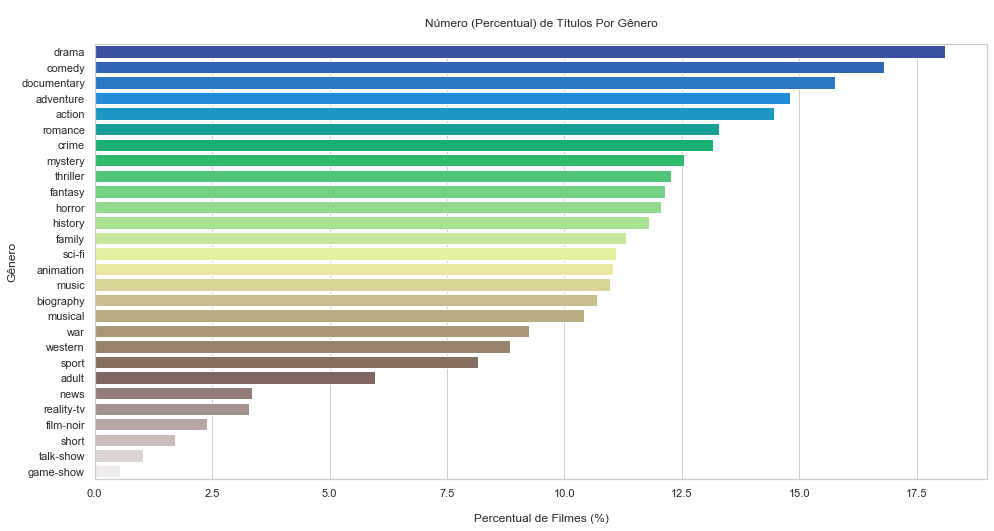

In [40]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()

## 3- Qual a Mediana de Avaliação dos Filmes Por Gênero?

Mediana de avaliação dos filmes.

In [41]:
# Consulta SQL
consulta3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ''' 

In [42]:
# Resultado
resultado3 = pd.read_sql_query(consulta3, conn)

In [43]:
# Visualiza
display(resultado3)

,rating,genres
0,4.5,\N
1,6.0,"Action,Adventure,Biography"
2,4.6,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
277180,5.8,Thriller
277181,6.4,"Drama,History"
277182,3.6,"Adventure,History,War"
277183,8.3,Drama


In [44]:
# Vamos criar uma função para retornar os genêros
def retorna_generos(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos =  vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [45]:
# Aplica a função
generos_unicos = retorna_generos(resultado3)

In [46]:
# Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [47]:
# Cria listas vazias
genero_counts = []
genero_ratings = []

In [48]:
# Loop
for item in generos_unicos:
    
    # Retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
  
     # Retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [50]:
# Prepara o dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [51]:
# Visualiza
df_genero_ratings.head(20)

,genres,count,rating
0,action,28680,5.8
1,adult,4364,5.9
2,adventure,17411,6.0
3,animation,4762,6.6
4,biography,8428,7.0
5,comedy,68592,6.0
6,crime,23662,6.1
7,documentary,41320,7.3
8,drama,122753,6.3
9,family,10709,6.3


In [52]:
# Drop do índice 18 (news)
# Não queremos essa informação como gênero
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [53]:
# Ordena o resultado
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

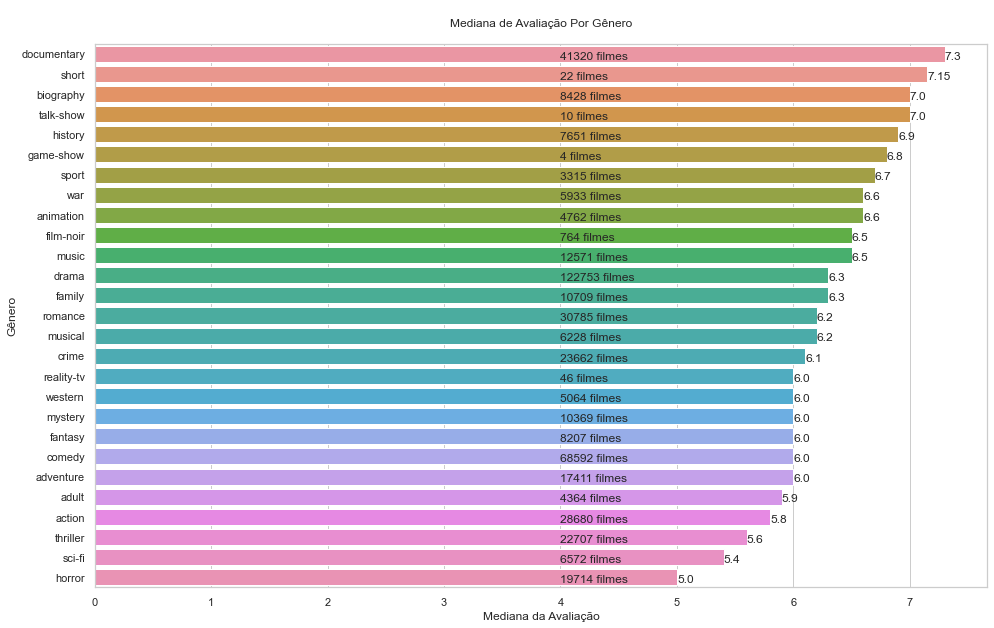

In [54]:
# Plot

# Figura
plt.figure(figsize = (16,10))

# Barplot
sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = "h")

# Textos do gráfico
for i in range(len(df_genero_ratings.index)):
    
    plt.text(4.0, 
             i + 0.25, 
             str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
             i + 0.25,
             round(df_genero_ratings["rating"][df_genero_ratings.index[i]],2))

plt.ylabel('Gênero')             
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação Por Gênero\n')
plt.show()

## 4- Qual a Mediana de Avaliação dos Filmes Em Relação ao Ano de Estréia?

Mediana de avaliação dos filmes.

In [55]:
# Consulta SQL
consulta4 = '''
            SELECT rating AS Rating, premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            ''' 

In [56]:
# Resultado
resultado4 = pd.read_sql_query(consulta4, conn)

In [57]:
display(resultado4)

,Rating,premiered
0,6.2,1896
1,4.5,1897
2,4.0,1899
3,3.7,1899
4,6.0,1900
...,...,...
277180,9.2,2022
277181,5.6,2022
277182,6.0,2022
277183,5.0,2022


In [58]:
# Calculamos a mediana ao longo do tempo (anos)
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [59]:
type(ratings)

list

In [60]:
ratings[1:10]

[4.5, 3.85, 5.85, 6.2, 3.4, 4.6, 5.3, 4.5, 3.6]

In [61]:
# Lista de anos
anos = list(set(resultado4['premiered']))

In [62]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

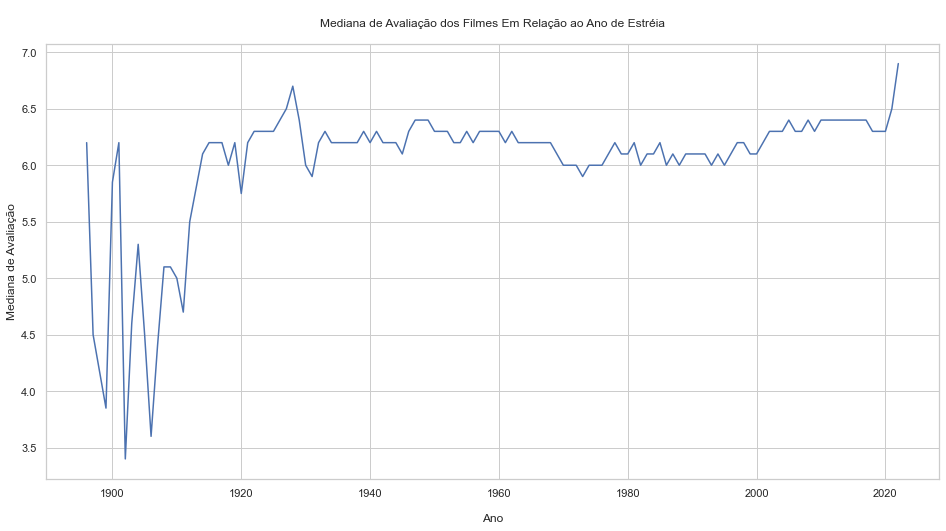

In [63]:
# Plot
plt.figure(figsize = (16,8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes Em Relação ao Ano de Estréia\n')
plt.show()

## 5- Qual o Número de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia?

Número de filmes por gênero. Vamos listar os Top 5.

In [64]:
# Consulta SQL
consulta5 = '''SELECT genres FROM titles ''' 

In [65]:
# Resultado
resultado5 = pd.read_sql_query(consulta5, conn)

In [66]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8852144,"Action,Drama,Family"
8852145,"Action,Drama,Family"
8852146,"Action,Drama,Family"
8852147,Short


In [67]:
# Retorna gêneros únicos
generos_unicos = retorna_generos(resultado5)

In [68]:
# Visualiza o resultado
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [69]:
# Agora fazemos a contagem
genero_count = []
for item in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [70]:
# Prepara o dataframe
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [71]:
# Calcula os top 5
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

Percebe-se que os filmes produzidos a partir dos anos 2000 são os que apresentam a maior quantidade de avaliação. Provavelmente este resultado tem forte influência da democratização da internet neste período, o que possibilitou a atuação do público na construção e/ou participação de avaliações de diversos tipos, entre inúmeras outras possibilidades de atuação que a democratização da internet potencializou.

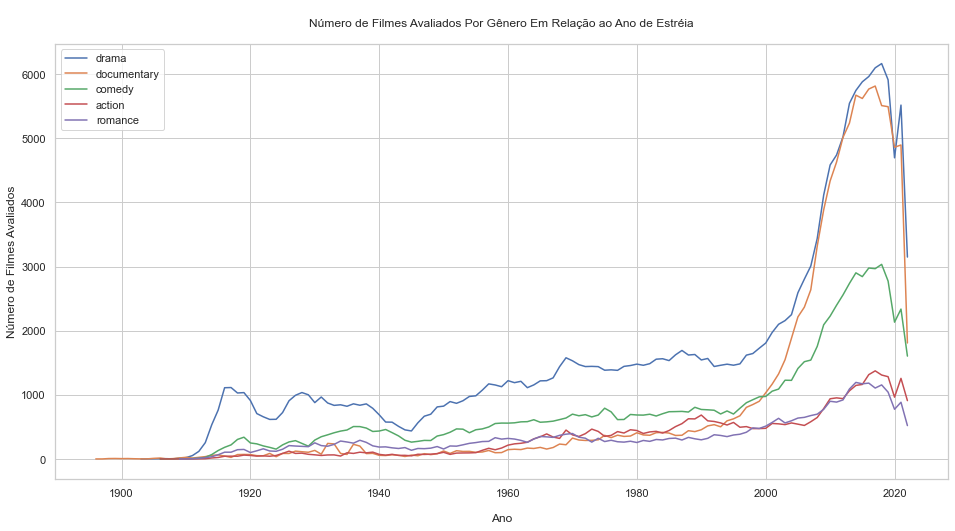

In [72]:
# Plot

# Figura
plt.figure(figsize = (16,8))

# Loop e Plot
for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <=2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados Por Gênero Em Relação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

## 6- Qual o Filme com Maior Tempo de Duração? Calcule os Percentis.

Percentis e filme mais longo da história. Os percentis são uma boa forma de detectar a presença de outliers. Após consulta na documentação para entender qual coluna apresentaria essa informação, neste caso a runtime. Além disso, na query SQL já filtro os valores ausentes (NaN).

In [73]:
# Consulta SQL para obter o tempo de duração de cada título 
consulta6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ''' 

In [74]:
# Resultado
resultado6 = pd.read_sql_query(consulta6, conn)

In [75]:
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
382109,123
382110,57
382111,100
382112,116


In [76]:
# Loop para cálculo dos percentis. Usando uma função nativa do numpy para o calculo de percentis.
for i in range(101): 
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 51.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 72.0
24 

O ultimo resultado sugere um outlier, dado que o tempo médio de duração dos títulos presente no DataFrame possuem 89 minutos de duração, segundo a mediana. Abaixo, refazemos a consulta para retornar especificamente o filme com maior duração.

In [77]:
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            ''' 

In [78]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [79]:
resultado6

,Runtime,primary_title
0,51420,Logistics


Após uma consulta na internet percebe-se que o filme 'Logistics' é o mais longo da história (até este momento), com 857 horas (51420 minutos). Dirigido por Daniel Andersson e Erika Magnusson, o filme acompanha todo o ciclo de vida de um pedômetro (dispositivo de rastreamento de passos) em ordem cronológica reversa. Assim, percebe-se que a informação não é um erro, embora ainda seja um outliner. A depender da análise que será feita com esses dados ele pode impactar e muito nos resultados de média, por exemplo, ou de modelos preditivos. Porém, nesse caso, ele não interferirá na análise.

## 7- Qual a Relação Entre Duração e Gênero?

Relação entre duração do filme e gênero.

In [80]:
# Consulta SQL para selecionar a duração média (avg) dos gêneros
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            ''' 

In [81]:
# Resultado
resultado7 = pd.read_sql_query(consulta7, conn)

In [82]:
# Retorna gêneros únicos
generos_unicos = retorna_generos(resultado7)

In [83]:
# Visualiza
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [84]:
# Calcula duração por gênero e preencho uma lista com essas informações
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [85]:
# Prepara o dataframe
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [86]:
# Remove índice 18 (news)
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [87]:
# Ordena os dados
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

### Relação entre duração e gênero:

Os filmes de romance são os que apresentam maior tempo de duração, seguidos do filme de ação. Em contrapartida, são os curtas que apresentam a menor duração.

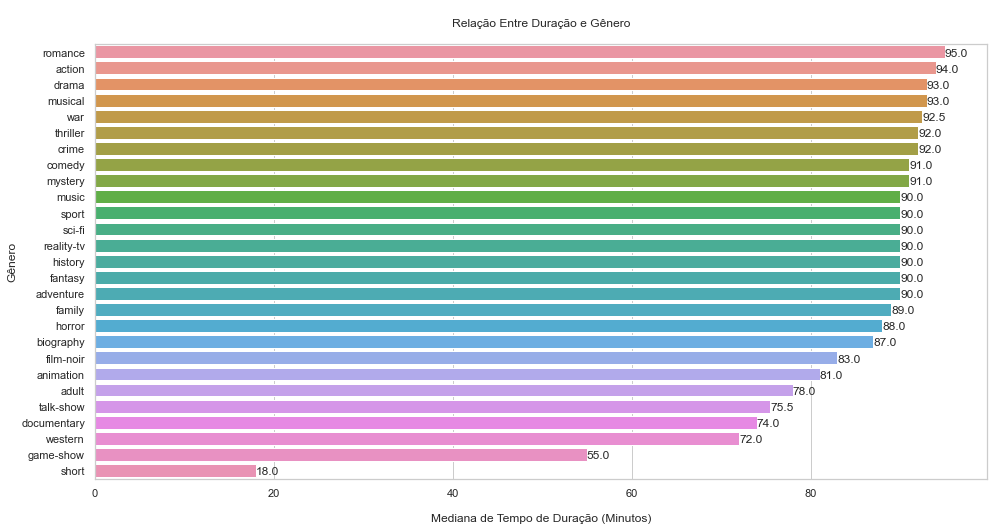

In [88]:
# Plot

# Tamanho da figura
plt.figure(figsize = (16,8))

# Barplot
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

# Loop
for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

## 8- Qual o Número de Filmes Produzidos Por País?

Número de filmes produzidos por país. A região onde cada filme foi produzido está na tabela akas, logo, iremos fazer uma contagem do numero de produções (do tipo filme) na tabela akas e agrupamos essas informações por região. Caso hajam regiões vazias (none) elas não entrarão na contagem. Buscando 

In [89]:
# Consulta SQL
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            ''' 

In [90]:
# Resultado
resultado8 = pd.read_sql_query(consulta8, conn)

In [91]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,6212
2,AF,113
3,AG,12
4,AL,1284
...,...,...
229,YUCS,153
230,ZA,3213
231,ZM,15
232,ZRCD,2


In [92]:
# Shape
resultado8.shape

(234, 2)

In [93]:
# Número de linhas
resultado8.shape[0]

234

In [94]:
# Listas auxiliares
nomes_paises = []
contagem = []

In [95]:
# Loop para obter o país de acordo com a região
# Farei um apêndice na lista nomes_paises, onde com ajuda do método get do pacote countries do pacote pycountry substituirei o código pelo nome do país correspondente
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [96]:
# Prepara o dataframe
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [97]:
# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [98]:
# Visualiza
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,310428
65,United Kingdom,159355
96,Japan,91271
63,France,84618
89,India,80900
32,Canada,77560
47,Germany,70713
26,Brazil,65447
93,Italy,65343
58,Spain,65318


### Listagem dos 10 países com produção cinematográfica mais expressiva e a quantidade de filmes produzidas em cada um deles.

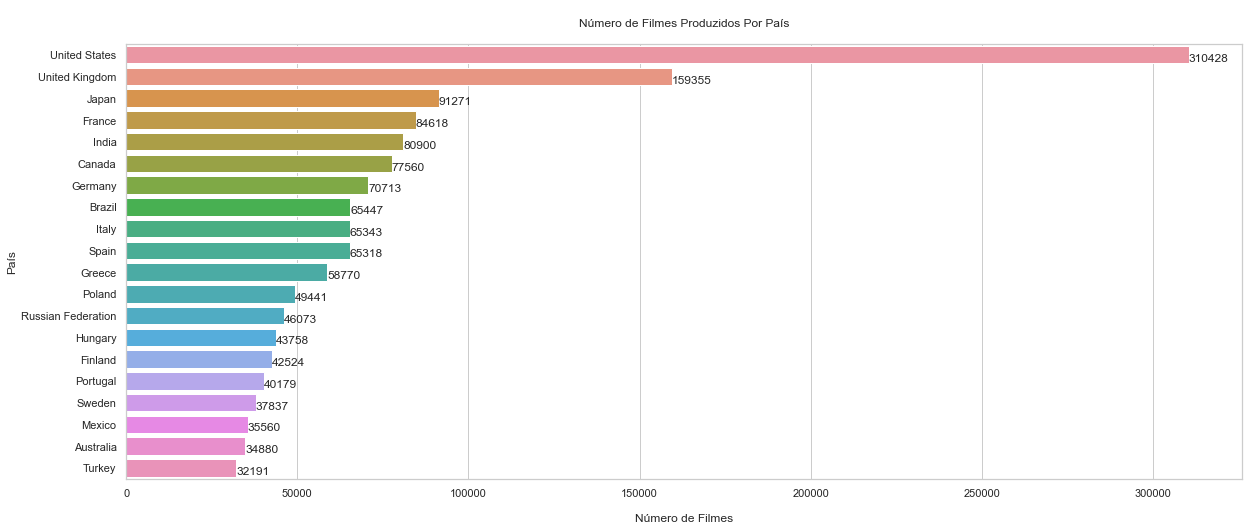

In [100]:
# Plot

# Figura
plt.figure(figsize = (20,8))

# Barplot
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

# Loop
for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

#### As duas últimas questõees possuem resultados inversos e podem ser respondidas a partir de uma única instrução SQL.

## 9- Quais São os Top 10 Melhores Filmes?

Na consulta SQL irei buscar o título do filme COMO nome do filme (apelido) retornando o genero e a avaliação a partir da tarbela títulos juntando com a tabela avaliações. Como filtros terei: o título do filme deve ser igual a filme E apenas filmes que possuem um número maior ou igual a 25000 avaliações. Ordenarei o resultado de forma decrescente e apresentarei apenas os 10 mais.

O filtro de 25000 é uma escolha da pessoa analista, que podem facilitar a compreensão do resultado, dado que neste caso optou-se por estabelecer um Top 10 a partir de filmes que possuem mais de 25000 avaliações. 


In [101]:
# Consulta SQL

consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            ''' 

In [102]:
# Resultado
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

### Listagem do Top 10 Melhores Filmes

In [102]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,Jai Bhim,"Crime,Drama,Mystery",9.4
1,The Shawshank Redemption,Drama,9.3
2,The Chaos Class,"Comedy,Drama",9.3
3,The Godfather,"Crime,Drama",9.2
4,Soorarai Pottru,Drama,9.2
5,Mirror Game,"Crime,Mystery,Thriller",9.2
6,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
7,12 Angry Men,"Crime,Drama",9.0
8,The Godfather: Part II,"Crime,Drama",9.0
9,Schindler's List,"Biography,Drama,History",9.0


## 10- Quais São os Top 10 Piores Filmes?

Top 10 filmes com pior avaliação e mais de 25 mil votos. A diferença para a resposta anterior é a listagem do resultado de maneira ascendente, assim terei as notas mais baixas no inicio da listagem.

In [103]:
# Consulta SQL
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            ''' 

### Listagem do Top 10 Piores Filmes

In [105]:
# Resultado
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [106]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.1
1,Sadak 2,"Action,Drama",1.1
2,Smolensk,"Drama,Thriller",1.2
3,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
4,Manos: The Hands of Fate,Horror,1.6
5,Reis,"Biography,Drama",1.6
6,The Cost of Deception,"Crime,Drama,History",1.7
7,Justin Bieber: Never Say Never,"Documentary,Music",1.7
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
